In [24]:
from prediction_pipeline import *
import pandas as pd
import torch
from deepirtools import IWAVE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

### Predictions

In [6]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

y_train = train_df['y']
X_train = train_df.drop(['y'], axis=1) 

y_test = test_df['y']
X_test = test_df.drop(['y'], axis=1)

## set train and test data, load model, get scores over X and X_train, use it as input for predictive models
## setup torch 
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
y = np.asarray(y_train)

# train
dft = torch.tensor(X_train_sc)
sample_size = X_train_sc.shape[0]
Y = dft.view(sample_size, -1)
n_items = Y.shape[1]

# test
dft_test = torch.tensor(X_test_sc)
sample_size_test = X_test_sc.shape[0]
Y_test = dft_test.view(sample_size_test, -1)
n_items_test = Y_test.shape[1]

In [7]:
latent_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size] # Find anchor items.
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)

model_name = 'train_iwave'
inf_net = [15,8]

# model
iwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3,
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = False,
              log_interval = 25,
              )

iwave.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  0.0  seconds


In [8]:
features_train = iwave.scores(Y, mc_samples=100, iw_samples=100)
features_test = iwave.scores(Y_test, mc_samples=100, iw_samples=100)


RESULTS: LOGISTIC REGRESSION

--- Stratified Cross-Validation Scores (5-Fold) ---
ROC-AUC CV: 0.8191 (+/- 0.0089)

--- Test Set Metrics ---
Accuracy: 0.7471
Precision: 0.7346
Recall: 0.7496
F1-Score: 0.7420
ROC-AUC: 0.8176

Confusion Matrix:
[[1471  504]
 [ 466 1395]]

RESULTS: RANDOM FOREST

--- Stratified Cross-Validation Scores (5-Fold) ---
ROC-AUC CV: 0.8169 (+/- 0.0092)

--- Test Set Metrics ---
Accuracy: 0.7466
Precision: 0.7386
Recall: 0.7394
F1-Score: 0.7390
ROC-AUC: 0.8175

Confusion Matrix:
[[1488  487]
 [ 485 1376]]


Text(0.5, 1.0, 'ROC AUC curve')

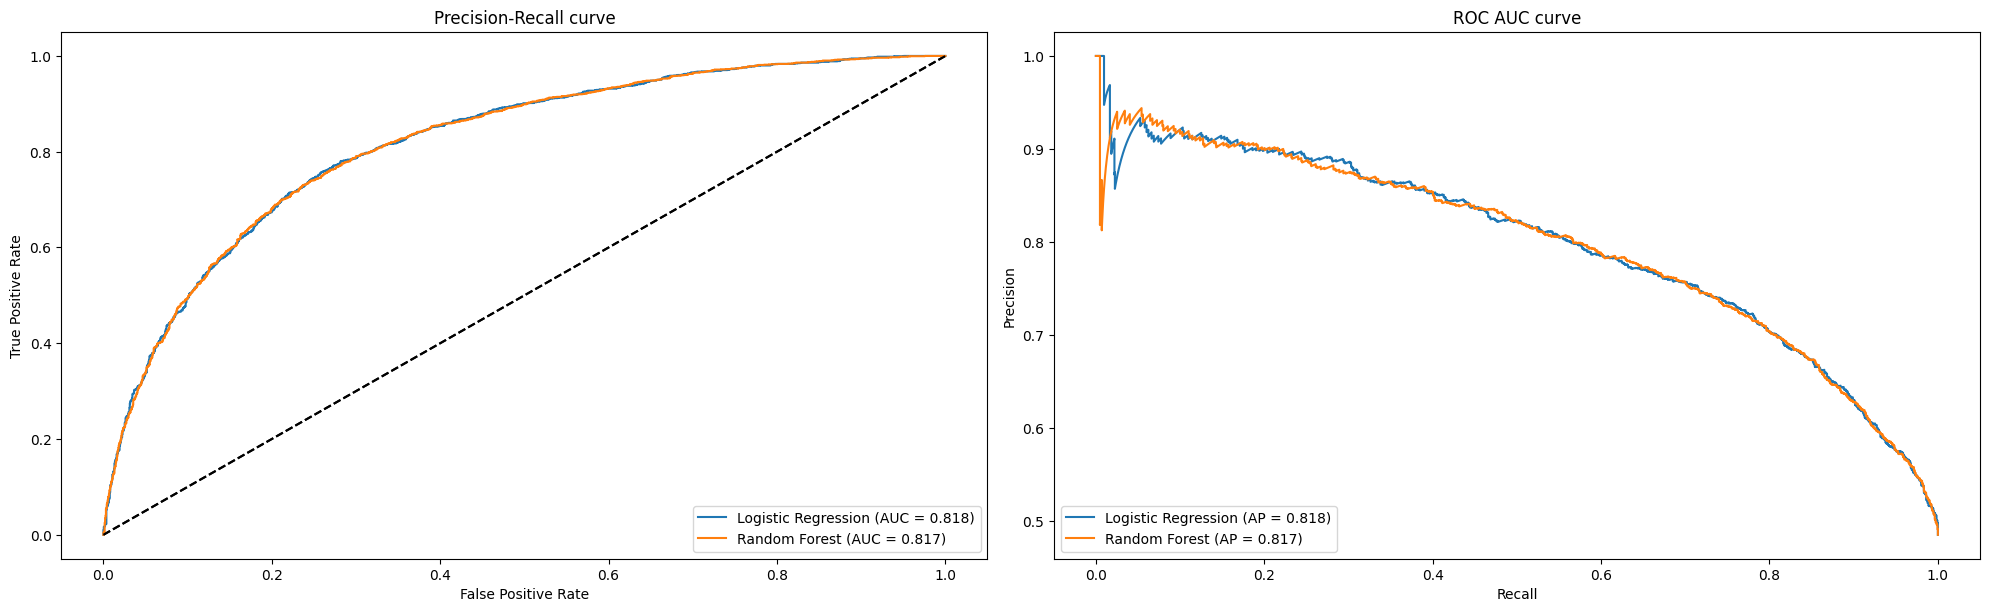

In [12]:

# Training models without optimizing hypermarameters for first analysis

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight='balanced',
    n_jobs = -1)

logi = LogisticRegression(
    penalty='l2', 
    solver='liblinear', 
    max_iter=100, 
    class_weight='balanced')

xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    # objective='binary:logistic',
    # eval_metric='logloss',
    # use_label_encoder=False,
    scale_pos_weight=10
    )

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

for model, model_name in [(logi, 'Logistic Regression'),
                          (rf, 'Random Forest'),
                        #   (xgb, 'XGB Classifier')
                          ]:
    model.fit(features_train, y_train)
    y_pred, y_pred_proba = evaluate_model(model,features_train, y_train, features_test, y_test, model_name)
    plot_results(y_test, y_pred_proba, model_name, ax1, ax2)
    # RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax1)
    # PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax2)


ax1.legend(loc="lower right")
ax1.set_title('Precision-Recall curve')

ax2.legend(loc="lower left")
ax2.set_title('ROC AUC curve')


In [ ]:
# iwave

# Extract features from your encoders
features = iwave.scores(Y, mc_samples=100, iw_samples=100)

# Tune and train models
models_results = {}
for model_name in ['logistic', 'rf', 'xgb', 'nn']:
    best_params, trials = tune_hyperparameters(model_name, X_train_sc, y_train)
    model = build_model(model_name, best_params)
    model.fit(X_train_sc, y_train)
    y_pred, y_pred_proba = evaluate_model(model, X_test_sc, y_test, model_name)
    plot_results(y_test, y_pred_proba, model_name)

In [13]:
# nIWAVE
model_name = 'train_niwave'
# load_model = os.path.exists(save_dir + '/' + model_name + '.pth')

# specs
latent_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)
inf_net = [15,8]

#### Load second model
model_name = 'niwave_male'
inf_net = [15,8]

niwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = True,
              count_bins = 32,
              flow_length = 2,
              log_interval = 25,
              )

niwave.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  28.9  seconds



RESULTS: LOGISTIC REGRESSION

--- Stratified Cross-Validation Scores (5-Fold) ---
ROC-AUC CV: 0.8196 (+/- 0.0105)

--- Test Set Metrics ---
Accuracy: 0.7513
Precision: 0.7368
Recall: 0.7582
F1-Score: 0.7474
ROC-AUC: 0.8180

Confusion Matrix:
[[1471  504]
 [ 450 1411]]

RESULTS: RANDOM FOREST

--- Stratified Cross-Validation Scores (5-Fold) ---
ROC-AUC CV: 0.8192 (+/- 0.0106)

--- Test Set Metrics ---
Accuracy: 0.7461
Precision: 0.7318
Recall: 0.7523
F1-Score: 0.7419
ROC-AUC: 0.8159

Confusion Matrix:
[[1462  513]
 [ 461 1400]]


C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: XGBClassifier should ei


RESULTS: XGB CLASSIFIER

--- Stratified Cross-Validation Scores (5-Fold) ---
ROC-AUC CV: nan (+/- nan)

--- Test Set Metrics ---
Accuracy: 0.5719
Precision: 0.5317
Recall: 0.9855
F1-Score: 0.6908
ROC-AUC: 0.8150

Confusion Matrix:
[[ 360 1615]
 [  27 1834]]


Text(0.5, 1.0, 'ROC AUC curve')

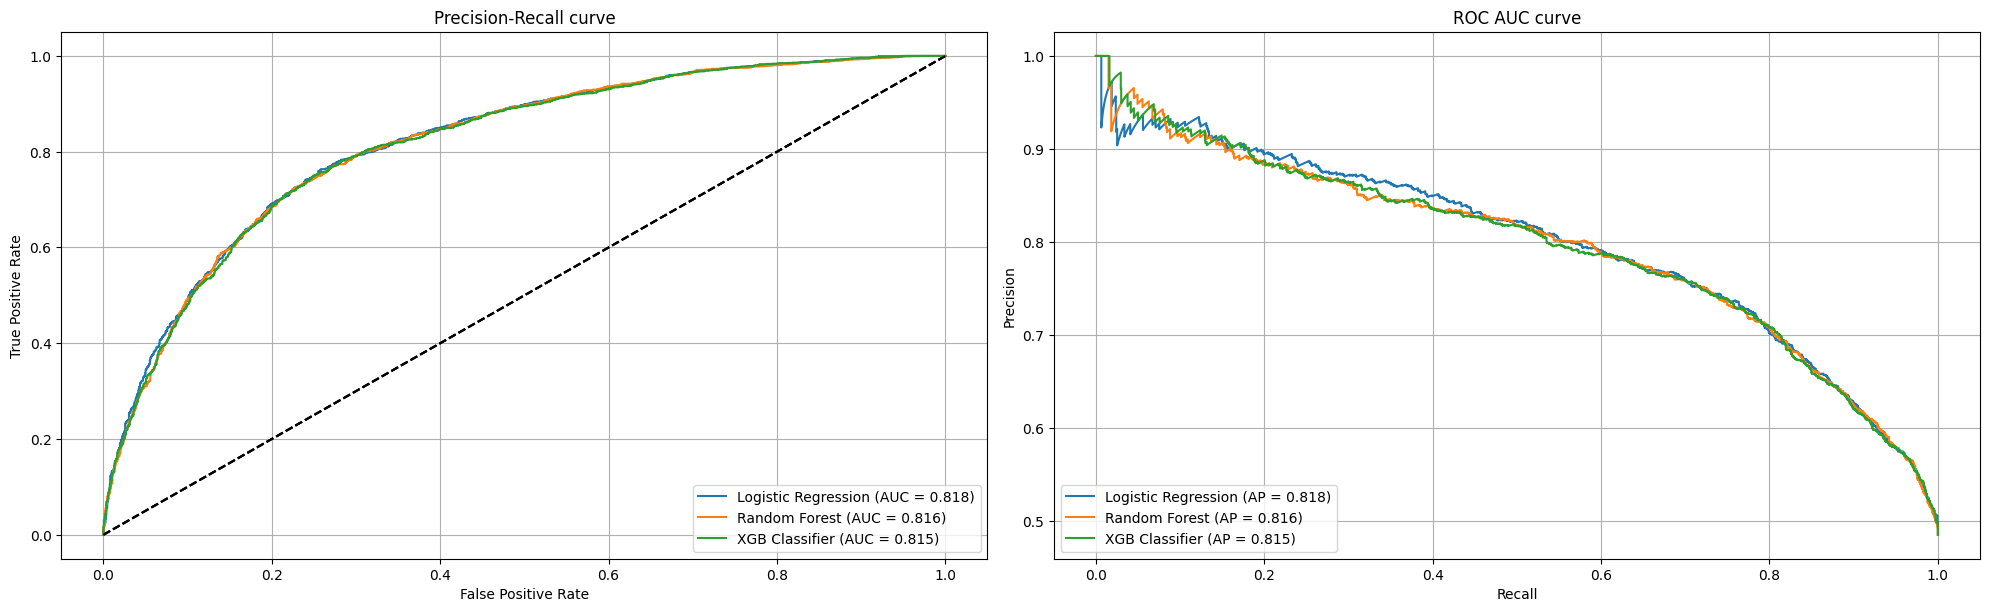

In [22]:
# ni-wave
# Extract features from your encoders
# features_train = niwave.scores(Y, mc_samples=100, iw_samples=100)
# features_test = niwave.scores(Y_test, mc_samples=100, iw_samples=100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

for model, model_name in [(logi, 'Logistic Regression'),
                          (rf, 'Random Forest'),
                          (xgb, 'XGB Classifier')
                          ]:
    model.fit(features_train, y_train)
    y_pred, y_pred_proba = evaluate_model(model,features_train, y_train, features_test, y_test, model_name)
    plot_results(y_test, y_pred_proba, model_name, ax1, ax2)


ax1.legend(loc="lower right")
ax1.set_title('Precision-Recall curve')

ax2.legend(loc="lower left")
ax2.set_title('ROC AUC curve')

In [17]:
# Convert torch tensors to numpy arrays and save to CSV
features_train_df = pd.DataFrame(features_train.numpy())
features_test_df = pd.DataFrame(features_test.numpy())

features_train_df.to_csv("../data/features_train_niwave.csv", index=False)
features_test_df.to_csv("../data/features_test_niwave.csv", index=False)

In [19]:
# Read the CSV files and convert to torch tensors
ft_train = pd.read_csv("../data/features_train_niwave.csv")
ft_test = pd.read_csv("../data/features_test_niwave.csv")

# Convert to torch tensors
features_train = torch.tensor(ft_train.values, dtype=torch.float32)
features_test = torch.tensor(ft_test.values, dtype=torch.float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

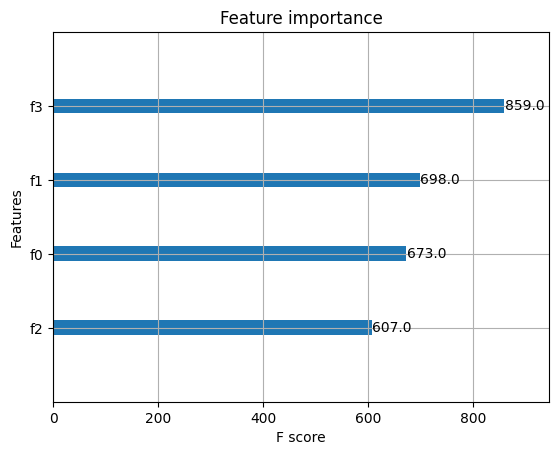

In [25]:
plot_importance(model, max_num_features = 4)

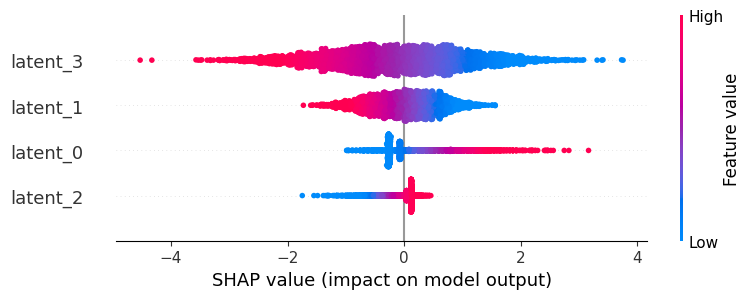

<Figure size 640x480 with 0 Axes>

In [21]:
import shap

import matplotlib.pyplot as plt

# Use the already trained logistic regression model and IWAVE features
explainer = shap.LinearExplainer(logi, features_train.numpy())
shap_values = explainer.shap_values(features_test.numpy())

# Summary plot of feature impact
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, features_test.numpy(), feature_names=[f"latent_{i}" for i in range(features_test.shape[1])])
plt.tight_layout()